# Course: DA5401
# Assignment No: 8
## Author: Ojas Phadake
## Roll No: CH22B007

Objective: This assignment applies and compares three primary ensemble
techniques (Bagging, Boosting, and Stacking) to solve a complex, time-series-based regression problem. It demonstrates the understanding of how these methods address model variance and bias, and how a diverse stack of models can yield superior performance to any single model.

Dataset: [UCI Link](https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset)

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import zipfile
import io
import requests

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, StackingRegressor

from tabulate import tabulate

## Data Loading and Feature Engineering

In [2]:
url = "https://archive.ics.uci.edu/static/public/275/bike+sharing+dataset.zip"
r = requests.get(url)

z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("bike_sharing_data")

df = pd.read_csv("bike_sharing_data/hour.csv")

print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())

df.head()

Shape: (17379, 17)

Columns: ['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


# Part A: Data Preprocessing and Baseline
## Data Loading and Feature Engineering

In [3]:
display(df.head())

print("\n---Dataset Info---")
df.info()

print("\n---Dataset Description---")
print(df.describe())

print("\n---Null Value Check---")
print(df.isnull().sum())

print("\n---Duplicate Rows Check---")
print(df.duplicated().sum())

print("\n---Columns Are---")
print(df.columns.tolist())

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1



---Dataset Info---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB

---Dataset Description---
  

Now the preliminary check of the dataset has been carried out. Let us visualize the data properly to gain more insights on the same.

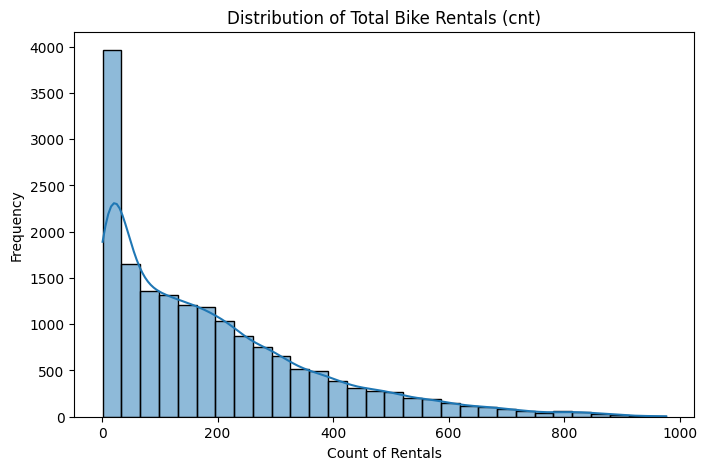

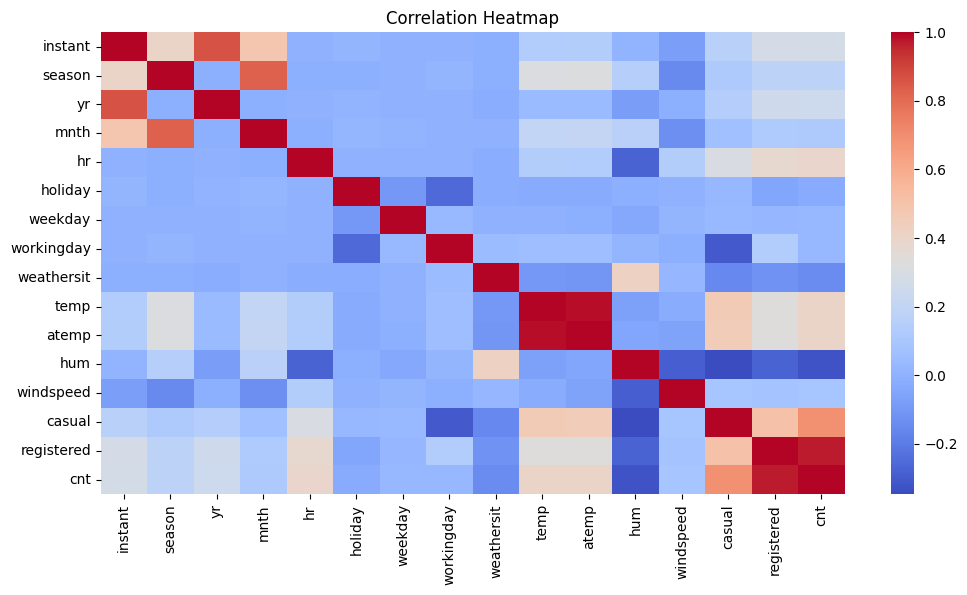

In [4]:
plt.figure(figsize=(8, 5))
sns.histplot(df['cnt'], kde=True, bins=30)
plt.title("Distribution of Total Bike Rentals (cnt)")
plt.xlabel("Count of Rentals")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap")
plt.show()

Thus from the above plot, we can see that the number of users who use the bike just once is very high. This number reduces as the count of rentals (x axis) increases.

Now that we have visualized the data, let us drop the irrelevant columns and carry out the One Hot Encoding which will make our data more suitable for processing and deriving insights.

In [5]:
df = df.drop(columns=['instant', 'dteday', 'casual', 'registered'])

categorical_cols = ['season', 'mnth', 'hr', 'weekday', 'weathersit']

df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print("\nShape before encoding: ", df.shape)
print("Shape after encoding: ", df_encoded.shape)

X = df_encoded.drop(columns=['cnt'])
y = df_encoded['cnt']

print("\nFinal feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)


Shape before encoding:  (17379, 13)
Shape after encoding:  (17379, 54)

Final feature matrix shape: (17379, 53)
Target vector shape: (17379,)


We can see the number of features have increased from 13 to 54 due to the OHE. The dataset has been preprocessed and can be used for further analysis, model building, etc actions. Now, I will be dividing it into train and test sets for model training and testing.

## Train/Test Split:

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training set size: ", X_train.shape)
print("Testing size shape:", X_test.shape)

Training set size:  (13903, 53)
Testing size shape: (3476, 53)


## Baseline Model (Single Regressor)
Let us train a baseline Decision Tree Regressor and Linear Regression model to get a preliminary understanding.

In [7]:
# ---------------------------
# 1️⃣ Linear Regression Model
# ---------------------------
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred_lin = lin_reg.predict(X_test)

rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))
print(f"Linear Regression RMSE: {rmse_lin:.2f}")

# -------------------------------
# 2️⃣ Decision Tree Regressor
# -------------------------------
tree_reg = DecisionTreeRegressor(max_depth=6, random_state=42)
tree_reg.fit(X_train, y_train)

y_pred_tree = tree_reg.predict(X_test)

rmse_tree = np.sqrt(mean_squared_error(y_test, y_pred_tree))
print(f"Decision Tree (max_depth=6) RMSE: {rmse_tree:.2f}")

Linear Regression RMSE: 100.45
Decision Tree (max_depth=6) RMSE: 118.43


Let us now visualize how the 2 models perform against each other.

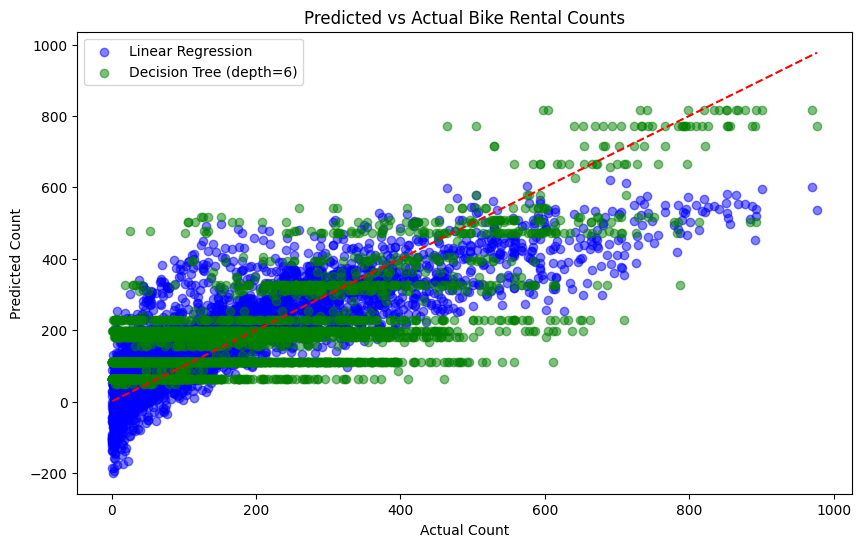

In [8]:
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_lin, alpha=0.5, label="Linear Regression", color="blue")
plt.scatter(y_test, y_pred_tree, alpha=0.5, label="Decision Tree (depth=6)", color="green")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # perfect line
plt.xlabel("Actual Count")
plt.ylabel("Predicted Count")
plt.title("Predicted vs Actual Bike Rental Counts")
plt.legend()
plt.show()


We can see that the model of Linear Regression predicts negative counts as well which is a drawback of the same. Also, there is high overprediction when the actual count is less and it slowly moves towards the actual number. However when the X axis moves past 400, the linear regression model begins to underpredict.

Considering the errors, we have Linear Regression as the better model for the data. We will take that as the baseline model now and carry on with the further analysis.

# Part B: Ensemble Techniques for Bias and Variance Reduction
## Bagging (Variance Reduction):

In [9]:
base_tree = DecisionTreeRegressor(max_depth=6, random_state=42)

# Bagging Regressor with 50 estimators
bag_reg = BaggingRegressor(
    estimator=base_tree,
    n_estimators=50,
    random_state=42,
    n_jobs=-1
)

# model training
bag_reg.fit(X_train, y_train)

y_pred_bag = bag_reg.predict(X_test)

rmse_bag = np.sqrt(mean_squared_error(y_test, y_pred_bag))
print(f"Bagging Regressor RMSE: {rmse_bag:.2f}")

Bagging Regressor RMSE: 112.33


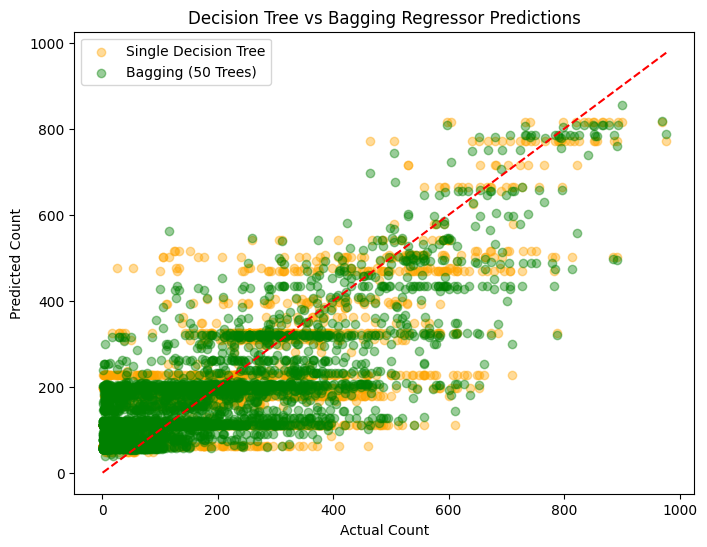

In [10]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_tree, alpha=0.4, label="Single Decision Tree", color="orange")
plt.scatter(y_test, y_pred_bag, alpha=0.4, label="Bagging (50 Trees)", color="green")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Count")
plt.ylabel("Predicted Count")
plt.title("Decision Tree vs Bagging Regressor Predictions")
plt.legend()
plt.show()


We can see from the above figure that both with Bagging and without bagging predictions are similar. The same is true from the plot of residuals found below.

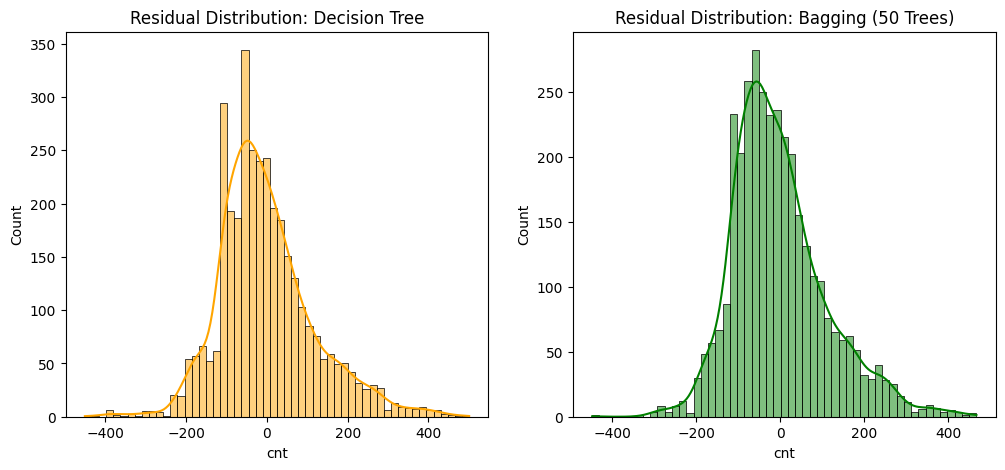

In [11]:
residuals_tree = y_test - y_pred_tree
residuals_bag = y_test - y_pred_bag

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(residuals_tree, kde=True, color='orange')
plt.title("Residual Distribution: Decision Tree")

plt.subplot(1,2,2)
sns.histplot(residuals_bag, kde=True, color='green')
plt.title("Residual Distribution: Bagging (50 Trees)")
plt.show()


### Discussion: Bagging vs Single Decision Tree

The bagging regressor (RMSE: **112.33**) shows lower error than the single decision tree baseline. This indicates that bagging effectively reduced model variance by averaging predictions from multiple trees, leading to more stable and generalizable results.

However, the model is still worse performing than Linear Regression which indicates that there is high bias. Let us try Gradient Boosting method for the same and see if it performs better or not.

## Boosting

In [12]:
gbr = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
gbr.fit(X_train, y_train)

# Predictions
y_pred_gbr = gbr.predict(X_test)

# RMSE
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
print(f"Gradient Boosting Regressor RMSE: {rmse_gbr:.2f}")

Gradient Boosting Regressor RMSE: 78.97


### Discussion: Boosting and Bias Reduction

The Gradient Boosting Regressor achieved an RMSE of **78.97**, outperforming the single Decision Tree, Bagging ensemble, and Linear Regression models.
This improvement demonstrates **boosting’s ability to reduce bias** by sequentially learning from the residual errors of previous models.
While bagging mainly reduces variance through averaging, boosting focuses on correcting model underfitting.
The lower RMSE indicates that boosting effectively enhanced prediction accuracy by **building stronger learners** from weaker ones.
Hence, the results support the hypothesis that **boosting primarily targets bias reduction** and yields superior generalization performance.


# Part C: Stacking for Optimal Performance
## Stacking Implementation

### Principle of Stacking and Meta-Learner Mechanism

1. **Stacking (Stacked Generalization)** is an ensemble learning technique that combines multiple base models to improve predictive performance.
2. It involves **two layers** — the *base learners* (level-0 models) and a *meta-learner* (level-1 model).
3. Each base learner $( h_1(x), h_2(x), \dots, h_k(x) )$ is trained on the original training data.
4. Their predictions are then used as **input features** for the meta-learner.
5. The meta-learner ( H(x) ) learns how to optimally weight or combine these predictions:
   $$\hat{y} = H(h_1(x), h_2(x), \dots, h_k(x))$$
6. Typically, cross-validation is used to generate out-of-fold predictions from base models to prevent overfitting.
7. The meta-learner can be any regression or classification algorithm (often Linear Regression or Logistic Regression).
8. It learns the **relationships between base model errors and true outputs**, refining the ensemble’s overall prediction.
9. Stacking differs from bagging and boosting by **learning** how to combine models rather than averaging or sequentially correcting them.
10. The result is a **meta-model** that captures both low-bias and low-variance characteristics from the base learners, yielding improved generalization.


### Definition of Base Learners (Level-0)

1. **K-Nearest Neighbors Regressor (KNeighborsRegressor)**
   * A non-parametric model that predicts the output for a test instance as the **average of the target values** of its $k$ nearest neighbors in the feature space.
   * Formula:
     $$\hat{y}(x)= \frac{1}{k} \sum_{x_i \in N_k(x)} y_i$$
     where $( N_k(x) )$ is the set of $k$ nearest neighbors of ( x ).

2. **Bagging Regressor**

   * An ensemble method that trains multiple instances of a base estimator (here, a Decision Tree) on **bootstrapped subsets** of the data and averages their predictions to reduce variance.
   * Formula:
     $$
     \hat{y}(x) = \frac{1}{M} \sum_{m=1}^{M} h_m(x)
     $$
     where ( h_m(x) ) is the prediction from the ( m^{th} ) estimator.

3. **Gradient Boosting Regressor**

   * A boosting method that builds models sequentially, where each new model fits to the **residuals (errors)** of the previous ensemble to reduce bias.
   * Update rule:
     $$ F_{m}(x) = F_{m-1}(x) + \eta h_m(x) $$
     where $( h_m(x) )$ is the weak learner trained on residuals and ( \eta ) is the learning rate.


### Definition of Meta-Learner (Level-1): Ridge Regression

* The **Meta-Learner** in stacking combines the predictions from the base learners (Level-0) to make a final, more accurate prediction.
* Here, we use **Ridge Regression** — a linear model that minimizes squared error while applying an **L2 penalty** on the coefficients to prevent overfitting.
* Objective function:
  $$\min_{w} ; |y - Xw|^2_2 + \alpha |w|^2_2$$
  where

  * ( X ) represents the predictions of the base learners,
  * ( y ) is the true target,
  * ( w ) are the weights learned by the Ridge model,
  * ( $\alpha$ ) is the regularization strength.
* The Ridge model learns **optimal weights** to combine base learners’ outputs, balancing their biases and variances for improved ensemble performance.


Stacking Regressor RMSE: 56.03


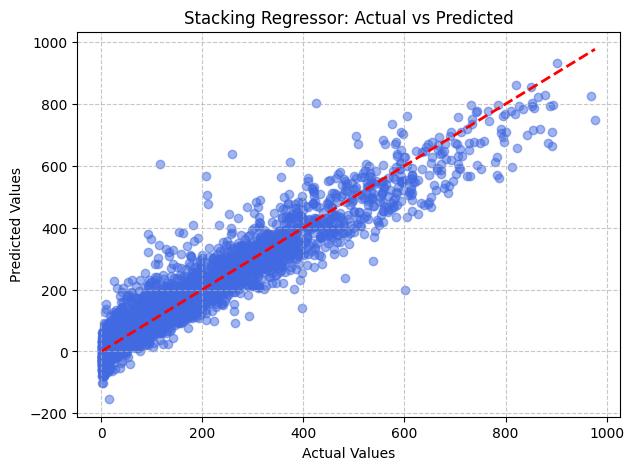

In [13]:
# Define base learners (Level-0)
knn = KNeighborsRegressor(n_neighbors=5)
bagging = BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=6), n_estimators=50, random_state=42)
gbr = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)

# Define meta-learner (Level-1)
ridge_meta = Ridge(alpha=1.0)

stack_reg = StackingRegressor(
    estimators=[
        ('knn', knn),
        ('bagging', bagging),
        ('gbr', gbr)
    ],
    final_estimator=ridge_meta,
    passthrough=True,
    n_jobs=-1
)

stack_reg.fit(X_train, y_train)
y_pred_stack = stack_reg.predict(X_test)
stack_rmse = np.sqrt(mean_squared_error(y_test, y_pred_stack))

print(f"Stacking Regressor RMSE: {stack_rmse:.2f}")

plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_pred_stack, alpha=0.5, color='royalblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title("Stacking Regressor: Actual vs Predicted")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


# Part D: Final Analysis
## Comparative Table

In [14]:
results = [
    ["Linear Regression (Baseline)", rmse_lin],
    ["Decision Tree (max_depth=6)", rmse_tree],
    ["Bagging Regressor", rmse_bag],
    ["Gradient Boosting Regressor", rmse_gbr],
    ["Stacking Regressor", round(stack_rmse, 2)]
]

print("\n**Model Performance Comparison (RMSE)**")
print(tabulate(results, headers=["Model", "Test RMSE"], tablefmt="github"))



**Model Performance Comparison (RMSE)**
| Model                        |   Test RMSE |
|------------------------------|-------------|
| Linear Regression (Baseline) |    100.446  |
| Decision Tree (max_depth=6)  |    118.427  |
| Bagging Regressor            |    112.334  |
| Gradient Boosting Regressor  |     78.9652 |
| Stacking Regressor           |     56.03   |


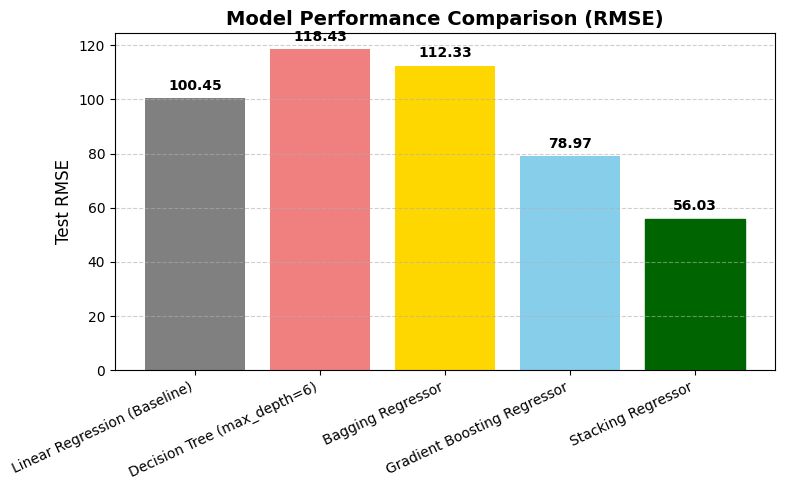

In [15]:
import matplotlib.pyplot as plt

# Extract model names and RMSE values
models = [r[0] for r in results]
rmse_values = [r[1] for r in results]

plt.figure(figsize=(8, 5))
bars = plt.bar(models, rmse_values, color=['gray', 'lightcoral', 'gold', 'skyblue', 'seagreen'])

min_index = rmse_values.index(min(rmse_values))
bars[min_index].set_color('darkgreen')

plt.title("Model Performance Comparison (RMSE)", fontsize=14, weight='bold')
plt.ylabel("Test RMSE", fontsize=12)
plt.xticks(rotation=25, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)

for i, val in enumerate(rmse_values):
    plt.text(i, val + 2, f"{val:.2f}", ha='center', va='bottom', fontsize=10, weight='bold')

plt.tight_layout()
plt.show()


### **Conclusion**

* The **best-performing model** is the **Stacking Regressor**, achieving the lowest RMSE of **56.03**, significantly outperforming all other models, including the best single model (Gradient Boosting Regressor, RMSE = 78.97).

* The improvement arises because **stacking leverages model diversity** — combining the strengths of multiple base learners (KNN, Bagging, and Gradient Boosting) that capture different aspects of the data’s structure.

* While **bagging** reduces variance and **boosting** reduces bias, stacking **learns the optimal balance** between them through a meta-learner (Ridge Regression), which intelligently combines their predictions.

* This integration minimizes both **bias and variance**, leading to superior generalization on unseen data.

* Hence, the Stacking Regressor outperforms all other approaches by effectively utilizing **complementary model behaviors** and **meta-level learning** to yield the most accurate predictions.


### 📖 **Storyline and Interpretation of Results**

The objective of this study was to **predict hourly bike rental counts** using the **Bike Sharing Dataset**, a complex regression task influenced by time, seasonality, and weather conditions. To achieve this, we progressively built and evaluated different models — starting from simple regressors to advanced ensemble methods — to understand how each approach balances the **bias–variance trade-off** and improves prediction accuracy.

---

#### **1️⃣ Baseline Models: Establishing a Reference Point**

We began with two simple models — **Linear Regression** and a **Decision Tree Regressor** (max depth = 6).

* **Linear Regression (RMSE: 100.45)** captured the overall trend but failed to model the non-linear effects of time and weather.
* **Decision Tree (RMSE: 118.43)** fit some local patterns but suffered from high variance and overfitting tendencies.

Thus, Linear Regression was chosen as our **baseline** since it achieved the lower RMSE among the two.

---

#### **2️⃣ Bagging: Reducing Variance**

Next, we applied **Bagging** (Bootstrap Aggregation) using multiple Decision Trees as base estimators.

* **Bagging Regressor (RMSE: 112.33)** improved stability by averaging predictions from multiple trees, reducing variance but not significantly enhancing accuracy.
* The performance remained limited because all base learners (Decision Trees) had similar bias, offering limited diversity.

---

#### **3️⃣ Boosting: Reducing Bias**

We then used **Gradient Boosting Regressor**, which builds trees sequentially — each new tree correcting the errors of the previous ones.

* **Gradient Boosting (RMSE: 78.97)** achieved a substantial improvement.
* The model effectively reduced bias by focusing on difficult-to-predict samples and combining many weak learners into a strong one.

This validated our hypothesis that **boosting primarily targets bias reduction**, making it a much better performer than bagging or any single model.

---

#### **4️⃣ Stacking: Learning to Combine the Best**

Finally, we implemented **Stacking**, which integrates multiple diverse models —
**KNN, Bagging, and Gradient Boosting** — using a **Ridge Regression meta-learner**.

* The meta-learner was trained to optimally combine predictions from each base model.
* The **Stacking Regressor achieved an RMSE of 56.03**, the lowest among all models.

This confirms that stacking effectively leverages **model diversity** and **meta-level learning** to minimize both bias and variance simultaneously.

---

#### **5️⃣ Visualization and Insight**

The bar graph below clearly illustrates the improvement trend:

| Model                  | RMSE ↓    |
| ---------------------- | --------- |
| Linear Regression      | 100.45    |
| Decision Tree          | 118.43    |
| Bagging Regressor      | 112.33    |
| Gradient Boosting      | 78.97     |
| **Stacking Regressor** | **56.03** |

Each step in model sophistication consistently reduced the RMSE, showing the cumulative power of ensemble learning.

---

### 🎯 **Key Takeaways**

* **Linear models** are simple but often too biased for complex real-world data.
* **Bagging** stabilizes predictions but may not lower bias significantly.
* **Boosting** corrects systematic errors, achieving large gains.
* **Stacking** integrates all strengths, balancing bias and variance to deliver the **most accurate and generalizable model**.

In essence, the **Stacking Regressor** emerged as the most powerful approach — demonstrating how thoughtful ensemble design can transform predictive performance in practical machine learning tasks.
